# Descriptive Statistics

This notebook generates descriptive statistics based on the filtered HMDA records in `data/processed/mortgage-records/filtered`. The key findings are logged in `output/logs/descriptive.txt`. Please see the methodology document for additional context regarding these calculations.

## Setup

In [1]:
import polars as pl
import seaborn as sns
from utils.expressions import (
    EXPR_ETHN_SIMPLE,
    EXPR_IS_CREDIT_DENIAL,
    EXPR_RACE_ETHN,
    EXPR_RACE_SIMPLE,
)
from utils.helpers import count_with_pct, make_logger, shift_columns_left
from utils.loaders import load_county_meta, load_hmda, load_lenders

In [2]:
log = make_logger("../output/logs/descriptive.txt")

## Load auxiliary datasets

In [3]:
lenders = load_lenders()
lenders.head()

lei,lender_name,lender_parent,lender_topholder,lender_agency,other_lender_code,lender_state,lender_assets,lender_year_max,lender_type
str,str,str,str,i64,i64,str,i64,i64,str
"""549300DKYWYDD1…","""SI Mortgage Co…",null,null,7,-1,null,-1,2018,"""bank_or_other"""
"""549300QZ613DTY…","""Ned Stevens In…",null,null,7,3,"""RI""",-1,2018,"""ind"""
"""549300983ZYTJM…","""Coastal Herita…","""SOUTH SHORE MU…","""SOUTH SHORE MU…",3,0,"""MA""",511852,2018,"""bank_or_other"""
"""984500DLB3V4F0…","""REDIGER INVEST…",null,null,9,5,"""CA""",-1,2018,"""bank_or_other"""
"""5493004XDYR0YX…","""Guaranty Bank …","""GUARANTY BANCO…","""GUARANTY BANCO…",2,0,"""CO""",3697445,2018,"""bank_or_other"""


In [4]:
county_meta = load_county_meta()
county_meta.head()

county_code,county_name
str,str
"""34001""","""Atlantic Count…"
"""34003""","""Bergen County"""
"""34005""","""Burlington Cou…"
"""34007""","""Camden County"""
"""34009""","""Cape May Count…"


## Load HMDA data

In [5]:
raw = load_hmda()
log(len(raw), "Total entries in filtered data")

Total entries in filtered data:


519624

In [6]:
(
    raw.group_by("loan_type")
    .count()
    .sort("loan_type")
    .pipe(log, "Applications by loan type")
)

Applications by loan type:


loan_type,count
i64,u32
1,396414
2,123210


In [7]:
(
    raw.group_by("loan_type", "activity_year")
    .count()
    .sort("loan_type", "activity_year")
    .pivot(
        index="activity_year",
        columns="loan_type",
        values="count",
        aggregate_function=None,
    )
    .pipe(log, "Applications by loan type and activity year")
)

Applications by loan type and activity year:


activity_year,1,2
i64,u32,u32
2018,70213,24714
2019,71309,25363
2020,84038,26982
2021,94742,26954
2022,76112,19197


In [8]:
conventional = raw.filter(pl.col("loan_type") == 1)
len(conventional)

396414

In [9]:
fha = raw.filter(pl.col("loan_type") == 2)
len(fha)

123210

## Actions/outcomes

In [10]:
ACTIONS_DICT = {
    1: "1 - Loan originated",
    2: "2 - Application approved but not accepted",
    3: "3 - Application denied",
    4: "4 - Application withdrawn by applicant",
    5: "5 - File closed for incompleteness",
    6: "6 - Purchased loan",
    7: "7 - Preapproval request denied",
    8: "8 - Preapproval request approved but not accepted",
}

In [11]:
(
    raw.with_columns(pl.col("action_taken").replace(ACTIONS_DICT))
    .group_by("loan_type", "action_taken")
    .count()
    .with_columns(
        (pl.col("count") / pl.col("count").sum().over("loan_type")).alias("prop")
    )
    .sort("loan_type", "action_taken")
    .pivot("prop", "action_taken", "loan_type", aggregate_function=None)
    .pipe(log, "Actions taken by loan type")
)

Actions taken by loan type:


action_taken,1,2
str,f64,f64
"""1 - Loan origi…",0.892352,0.831394
"""2 - Applicatio…",0.028205,0.03266
"""3 - Applicatio…",0.079442,0.135947


## Denial rates by year

In [12]:
(
    raw.filter(pl.col("loan_type").eq(1))
    .group_by("activity_year")
    .agg(pl.col("action_taken").eq(3).mean().alias("denied"))
    .select("activity_year", "denied")
    .sort("activity_year")
    .pipe(log, "Conventional loan denial rates by year")
)

Conventional loan denial rates by year:


activity_year,denied
i64,f64
2018,0.08638
2019,0.077816
2020,0.079405
2021,0.072386
2022,0.08339


## Ethnicity

### Conventional loans

#### Ethnicity proportions

In [13]:
(
    conventional.with_columns(EXPR_ETHN_SIMPLE)
    .pipe(count_with_pct, "applicant_ethnicity_1")
    .pipe(log, "Detailed ethnicity counts, conventional")
)

Detailed ethnicity counts, conventional:


applicant_ethnicity_1,count,pct
i64,u32,f64
1,39339,9.9
2,300069,75.7
3,54149,13.7
4,110,0.0
11,177,0.0
12,595,0.2
13,140,0.0
14,1646,0.4
null,189,0.0


In [14]:
(
    conventional.with_columns(
        pl.col("applicant_ethnicity_1").str.replace(r"^1\d", "1X")
    )
    .pipe(count_with_pct, "applicant_ethnicity_1")
    .pipe(log, "Ethnicity counts with 11/12/13/14 codes -> 1X, conventional")
)

Ethnicity counts with 11/12/13/14 codes -> 1X, conventional:


applicant_ethnicity_1,count,pct
str,u32,f64
"""1""",39339,9.9
"""1X""",2558,0.6
"""2""",300069,75.7
"""3""",54149,13.7
"""4""",110,0.0
null,189,0.0


In [15]:
(
    conventional.with_columns(EXPR_ETHN_SIMPLE)
    .pipe(count_with_pct, "ethn_simple")
    .pipe(log, "Simplified ethnicity counts, conventional")
)

Simplified ethnicity counts, conventional:


ethn_simple,count,pct
i64,u32,f64
1,41897,10.6
2,300069,75.7
3,54149,13.7
4,110,0.0
null,189,0.0


In [16]:
(
    conventional.with_columns(EXPR_ETHN_SIMPLE)
    .filter(pl.col("ethn_simple") < 3)
    .pipe(count_with_pct, "ethn_simple")
    .pipe(log, "Ethnicity rates where known, conventional")
)

Ethnicity rates where known, conventional:


ethn_simple,count,pct
i64,u32,f64
1,41897,12.3
2,300069,87.7


#### Second-listed ethnicities

In [17]:
(
    conventional.pipe(count_with_pct, "applicant_ethnicity_2").pipe(
        log, "Second-listed ethnicities, conventional"
    )
)

Second-listed ethnicities, conventional:


applicant_ethnicity_2,count,pct
i64,u32,f64
1,64,0.0
2,339,0.1
11,1885,0.5
12,4577,1.2
13,1087,0.3
14,8338,2.1
null,380124,95.9


In [18]:
(
    conventional.with_columns(
        (pl.col("applicant_ethnicity_1").cast(str).str.slice(0, 1) == "1").alias(
            "latino_first"
        ),
        (pl.col("applicant_ethnicity_2").cast(str).str.slice(0, 1) == "1").alias(
            "latino_second"
        ),
    )
    .pipe(count_with_pct, "latino_first", "latino_second")
    .pipe(log, "First vs. second ethnicities, conventional")
)

First vs. second ethnicities, conventional:


latino_first,latino_second,count,pct
bool,bool,u32,f64
false,true,729,0.2
false,null,353599,89.2
true,false,339,0.1
true,true,15222,3.8
true,null,26336,6.6
null,null,189,0.0


#### Nulls

Nulls seem to be due to free-form text:

In [19]:
(
    conventional.filter(pl.col("applicant_ethnicity_1").is_null())[
        "derived_ethnicity"
    ].value_counts()
)

derived_ethnicity,counts
str,u32
"""Free Form Text…",189


### FHA loans

#### Ethnicity proportions

In [20]:
(
    fha.with_columns(EXPR_ETHN_SIMPLE)
    .pipe(count_with_pct, "applicant_ethnicity_1")
    .pipe(log, "Detailed ethnicity counts, FHA")
)

Detailed ethnicity counts, FHA:


applicant_ethnicity_1,count,pct
i64,u32,f64
1,32432,26.3
2,73633,59.8
3,16195,13.1
4,51,0.0
11,71,0.1
12,287,0.2
13,52,0.0
14,475,0.4
null,14,0.0


In [21]:
(
    fha.with_columns(pl.col("applicant_ethnicity_1").str.replace(r"^1\d", "1X"))
    .pipe(count_with_pct, "applicant_ethnicity_1")
    .pipe(log, "Ethnicity counts with 11/12/13/14 codes -> 1X, FHA")
)

Ethnicity counts with 11/12/13/14 codes -> 1X, FHA:


applicant_ethnicity_1,count,pct
str,u32,f64
"""1""",32432,26.3
"""1X""",885,0.7
"""2""",73633,59.8
"""3""",16195,13.1
"""4""",51,0.0
null,14,0.0


In [22]:
(
    fha.with_columns(EXPR_ETHN_SIMPLE)
    .pipe(count_with_pct, "ethn_simple")
    .pipe(log, "Simplified ethnicity counts, FHA")
)

Simplified ethnicity counts, FHA:


ethn_simple,count,pct
i64,u32,f64
1,33317,27.0
2,73633,59.8
3,16195,13.1
4,51,0.0
null,14,0.0


In [23]:
(
    fha.with_columns(EXPR_ETHN_SIMPLE)
    .filter(pl.col("ethn_simple") < 3)
    .pipe(count_with_pct, "ethn_simple")
).pipe(log, "Ethnicity rates where known, FHA")

Ethnicity rates where known, FHA:


ethn_simple,count,pct
i64,u32,f64
1,33317,31.2
2,73633,68.8


#### Second-listed ethnicities

In [24]:
(
    fha.pipe(count_with_pct, "applicant_ethnicity_2").pipe(
        log, "Second-listed ethnicities, FHA"
    )
)

Second-listed ethnicities, FHA:


applicant_ethnicity_2,count,pct
i64,u32,f64
1,36,0.0
2,155,0.1
11,1386,1.1
12,3807,3.1
13,400,0.3
14,5824,4.7
null,111602,90.6


## Ethnicity observation methods

In [25]:
(
    raw.with_columns(EXPR_ETHN_SIMPLE)
    .filter(pl.col("ethn_simple").le(2))
    .group_by("loan_type", "ethn_simple", "applicant_ethnicity_observed")
    .count()
    .with_columns(
        (
            pl.col("count") / pl.col("count").sum().over("loan_type", "ethn_simple")
        ).alias("prop")
    )
    .sort("loan_type", "ethn_simple", "applicant_ethnicity_observed")
    .pivot(
        "prop",
        ("loan_type", "ethn_simple"),
        "applicant_ethnicity_observed",
        aggregate_function=None,
    )
    .pipe(log, "Ethnicity observation method by loan type and simplified ethnicity")
)

Ethnicity observation method by loan type and simplified ethnicity:


loan_type,ethn_simple,1,2,3
i64,i64,f64,f64,f64
1,1,0.01962,0.903812,0.076569
1,2,0.012354,0.920658,0.066988
2,1,0.028604,0.871447,0.099949
2,2,0.02302,0.887252,0.089729


#### Compared to observation method for race/sex

In [26]:
(
    raw.filter(~pl.col("applicant_race_1").is_in([6, 7]).fill_null(True))
    .group_by("loan_type", "applicant_race_observed")
    .count()
    .with_columns(
        (pl.col("count") / pl.col("count").sum().over("loan_type")).alias("prop")
    )
    .sort("loan_type", "applicant_race_observed")
    .pivot("prop", "loan_type", "applicant_race_observed", aggregate_function=None)
    .pipe(log, "Race observation method by loan type")
)

Race observation method by loan type:


loan_type,1,2,3
i64,f64,f64,f64
1,0.013582,0.917551,0.068867
2,0.026385,0.879879,0.093736


In [27]:
(
    raw.filter(~pl.col("applicant_sex").is_in([3, 4]).fill_null(True))
    .group_by("loan_type", "applicant_sex_observed")
    .count()
    .with_columns(
        (pl.col("count") / pl.col("count").sum().over("loan_type")).alias("prop")
    )
    .sort("loan_type", "applicant_sex_observed")
    .pivot("prop", "loan_type", "applicant_sex_observed", aggregate_function=None)
    .pipe(log, "Sex observation method by loan type")
)

Sex observation method by loan type:


loan_type,1,2,3
i64,f64,f64,f64
1,0.013021,0.918908,0.068071
2,0.022921,0.883595,0.093484


## Race and race/ethnicity combination

### Simplified race variable

In [28]:
(
    raw.select(EXPR_RACE_SIMPLE)
    .pipe(count_with_pct, "race_simple")
    .sort("count", descending=True)
    .pipe(log, "Simplified race counts, overall")
)

Simplified race counts, overall:


race_simple,count,pct
str,u32,f64
"""white""",327725,63.1
"""missing""",78324,15.1
"""asian""",64394,12.4
"""black""",46660,9.0
"""native""",1670,0.3
"""pacific_island…",851,0.2


In [29]:
(
    raw.group_by("applicant_race_1", EXPR_RACE_SIMPLE)
    .count()
    .sort("applicant_race_1", "race_simple")
    .pipe(log, "applicant_race_1 -> race_simple assignments")
)

applicant_race_1 -> race_simple assignments:


applicant_race_1,race_simple,count
i64,str,u32
null,"""missing""",88
1,"""native""",1670
2,"""asian""",54936
3,"""black""",46660
4,"""pacific_island…",558
5,"""white""",327725
6,"""missing""",78077
7,"""missing""",159
21,"""asian""",6353


In [30]:
(
    raw.with_columns(EXPR_ETHN_SIMPLE)
    .with_columns(EXPR_RACE_SIMPLE)
    .filter(pl.col("ethn_simple").eq(1))
    .group_by("loan_type", "race_simple")
    .count()
    .with_columns(
        (pl.col("count") / pl.col("count").sum().over("loan_type")).alias("prop")
    )
    .sort("loan_type", "prop", descending=(False, True))
    .pivot("prop", "race_simple", "loan_type", aggregate_function=None)
    .pipe(log, "Race for H/L, by loan type")
)

Race for H/L, by loan type:


race_simple,1,2
str,f64,f64
"""white""",0.767263,0.81715
"""missing""",0.154832,0.120329
"""black""",0.04017,0.046463
"""asian""",0.021147,0.004802
"""native""",0.011313,0.007564
"""pacific_island…",0.005275,0.003692


In [31]:
(
    raw.with_columns(EXPR_ETHN_SIMPLE)
    .with_columns(EXPR_RACE_SIMPLE)
    .filter(pl.col("ethn_simple").eq(1))
    .filter(~pl.col("race_simple").eq("missing"))
    .group_by("loan_type", "race_simple")
    .count()
    .with_columns(
        (pl.col("count") / pl.col("count").sum().over("loan_type")).alias("prop")
    )
    .sort("loan_type", "prop", descending=(False, True))
    .pivot("prop", "race_simple", "loan_type", aggregate_function=None)
    .pipe(log, "Race for H/L, excl. missing")
)

Race for H/L, excl. missing:


race_simple,1,2
str,f64,f64
"""white""",0.907823,0.928927
"""black""",0.047529,0.052818
"""asian""",0.025021,0.005459
"""native""",0.013386,0.008598
"""pacific_island…",0.006241,0.004197


### `race_ethn` variable

In [32]:
(
    raw.with_columns(EXPR_ETHN_SIMPLE)
    .with_columns(EXPR_RACE_SIMPLE)
    .with_columns(EXPR_RACE_ETHN)["race_ethn"]
    .value_counts(sort=True)
    .pipe(log, "race_ethn counts, overall")
)

race_ethn counts, overall:


race_ethn,counts
str,u32
"""white""",268354
"""hl""",75214
"""missing""",67828
"""asian""",63348
"""black""",43429
"""native""",944
"""pacific_island…",507


In [33]:
(
    raw.with_columns(EXPR_ETHN_SIMPLE)
    .with_columns(EXPR_RACE_SIMPLE)
    .with_columns(EXPR_RACE_ETHN)
    .group_by("race_simple", "ethn_simple", "race_ethn")
    .count()
    .sort("race_simple", "ethn_simple", "race_ethn")
    .pipe(log, "race_simple + ethn_simple -> race_ethn, overall")
)

race_simple + ethn_simple -> race_ethn, overall:


race_simple,ethn_simple,race_ethn,count
str,i64,str,u32
"""asian""",null,"""asian""",60
"""asian""",1,"""hl""",1046
"""asian""",2,"""asian""",61268
"""asian""",3,"""asian""",2009
"""asian""",4,"""asian""",11
"""black""",null,"""black""",25
"""black""",1,"""hl""",3231
"""black""",2,"""black""",41800
"""black""",3,"""black""",1590


## Aggregate metrics by loan type, county, etc.

In [34]:
raw_with_race_ethn = (
    raw.with_columns(EXPR_ETHN_SIMPLE)
    .with_columns(EXPR_RACE_SIMPLE)
    .with_columns(EXPR_RACE_ETHN)
)

In [35]:
AGG_DEMOG_MISSING = (
    (pl.col("ethn_simple").gt(2).mean().alias("prop_ethn_missing")),
    (
        pl.col("applicant_race_1")
        .is_in([6, 7])
        .fill_null(True)
        .mean()
        .alias("prop_race_missing")
    ),
    (
        pl.col("applicant_sex")
        .is_in([3, 4])
        .fill_null(True)
        .mean()
        .alias("prop_sex_missing")
    ),
)

AGG_CORE_METRICS = (
    pl.count().alias("decisions"),
    AGG_DEMOG_MISSING[0],
    (pl.col("ethn_simple").eq(1).mean().alias("prop_hl")),
    (
        pl.col("ethn_simple")
        .filter(pl.col("ethn_simple").le(2))
        .eq(1)
        .mean()
        .alias("prop_hl_excl_miss")
    ),
    (pl.col("action_taken").eq(3).mean().alias("denied")),
    (
        pl.col("action_taken")
        .filter(pl.col("applicant_race_1").eq(5))
        # Only explicitly non-H/L
        .filter(pl.col("ethn_simple").eq(2))
        .eq(3)
        .mean()
        .alias("denied_white_nonhl_strict")
    ),
    (
        pl.col("action_taken")
        .filter(pl.col("applicant_race_1").eq(5))
        # Excluding explicitly H/L *and* missing ethnicity
        .filter(pl.col("ethn_simple").gt(1))
        .eq(3)
        .mean()
        .alias("denied_white_nonhl_loose")
    ),
    (
        pl.col("action_taken")
        .filter(pl.col("ethn_simple").eq(1))
        .eq(3)
        .mean()
        .alias("denied_hl")
    ),
)

### Loan type

In [36]:
(
    raw_with_race_ethn.group_by("loan_type")
    .agg(AGG_DEMOG_MISSING)
    .pipe(log, "Missing demographics by loan type")
)

Missing demographics by loan type:


loan_type,prop_ethn_missing,prop_race_missing,prop_sex_missing
i64,f64,f64,f64
1,0.13694,0.147871,0.059014
2,0.131871,0.159938,0.04959


In [37]:
loan_type_aggregates = (
    raw_with_race_ethn.group_by("loan_type")
    .agg(AGG_CORE_METRICS)
    .sort("loan_type")
    .pipe(log, "Aggregate metrics by loan type")
)

loan_type_aggregates

Aggregate metrics by loan type:


loan_type,decisions,prop_ethn_missing,prop_hl,prop_hl_excl_miss,denied,denied_white_nonhl_strict,denied_white_nonhl_loose,denied_hl
i64,u32,f64,f64,f64,f64,f64,f64,f64
1,396414,0.13694,0.10574,0.122518,0.079442,0.057896,0.058442,0.113158
2,123210,0.131871,0.270439,0.311519,0.135947,0.102471,0.104026,0.137227


In [38]:
(
    raw_with_race_ethn.filter(~pl.col("action_taken").eq(2))
    .group_by("loan_type")
    .agg(AGG_CORE_METRICS)
    .sort("loan_type")
    .pipe(log, "Aggregate metrics by loan type, excl. applicant-rejected")
)

Aggregate metrics by loan type, excl. applicant-rejected:


loan_type,decisions,prop_ethn_missing,prop_hl,prop_hl_excl_miss,denied,denied_white_nonhl_strict,denied_white_nonhl_loose,denied_hl
i64,u32,f64,f64,f64,f64,f64,f64,f64
1,385233,0.136648,0.105896,0.122657,0.081748,0.059473,0.060039,0.116272
2,119186,0.131491,0.270349,0.311279,0.140537,0.105457,0.107108,0.141908


In [39]:
(
    raw_with_race_ethn.filter(~EXPR_IS_CREDIT_DENIAL)
    .group_by("loan_type")
    .agg(AGG_CORE_METRICS)
    .pipe(log, "Aggregate metrics by loan type, excl. credit denials")
)

Aggregate metrics by loan type, excl. credit denials:


loan_type,decisions,prop_ethn_missing,prop_hl,prop_hl_excl_miss,denied,denied_white_nonhl_strict,denied_white_nonhl_loose,denied_hl
i64,u32,f64,f64,f64,f64,f64,f64,f64
1,387402,0.13573,0.104877,0.121347,0.058028,0.042067,0.042422,0.085075
2,118254,0.130688,0.272185,0.313104,0.099734,0.070446,0.071746,0.106854


### Lender ethnicity-missing

In [40]:
log(raw.select(pl.col("lei").n_unique()), "Total number of lenders")

Total number of lenders:


lei
u32
815


In [41]:
log(
    raw.group_by("loan_type").agg(pl.col("lei").n_unique()),
    "Number of lenders, by loan type",
)

Number of lenders, by loan type:


loan_type,lei
i64,u32
1,800
2,409


In [42]:
(raw.select(pl.col("lei").is_in(lenders["lei"]).mean()))

lei
f64
1.0


In [43]:
lender_aggregates = (
    raw_with_race_ethn.group_by("lei", "loan_type")
    .agg(AGG_CORE_METRICS)
    .sort("decisions", "lei", "loan_type", descending=(True, False, False))
    .pipe(shift_columns_left, ("lei",))
)

lender_aggregates.head()

lei,loan_type,decisions,prop_ethn_missing,prop_hl,prop_hl_excl_miss,denied,denied_white_nonhl_strict,denied_white_nonhl_loose,denied_hl
str,i64,u32,f64,f64,f64,f64,f64,f64,f64
"""KB1H1DSPRFMYMC…",1,23316,0.096183,0.104162,0.115247,0.120389,0.086568,0.087594,0.202484
"""549300FGXN1K3H…",1,18768,0.245098,0.083866,0.111095,0.137042,0.113783,0.114249,0.175985
"""B4TYDEB6GKMZO0…",1,14762,0.140515,0.078862,0.091755,0.101477,0.080099,0.080352,0.169244
"""549300HW662MN1…",1,14729,0.114332,0.102315,0.115523,0.075294,0.060519,0.061422,0.102853
"""7H6GLXDRUGQFU5…",1,13476,0.072351,0.123108,0.132709,0.084817,0.063221,0.063377,0.13261


In [44]:
(
    lender_aggregates.filter(pl.col("decisions") >= 1e3)
    .group_by("loan_type")
    .count()
    .sort("loan_type")
    .pipe(log, "Number of lenders w/ 1,000+ decisions, by loan type")
)

Number of lenders w/ 1,000+ decisions, by loan type:


loan_type,count
i64,u32
1,83
2,41


In [45]:
(
    lender_aggregates.filter(pl.col("decisions") >= 1e4)
    .group_by("loan_type")
    .count()
    .pipe(log, "Number of lenders w/ 10,000+ decisions, by loan type")
)

Number of lenders w/ 10,000+ decisions, by loan type:


loan_type,count
i64,u32
1,8


In [46]:
(
    lender_aggregates.filter(pl.col("decisions") >= 1e3)
    .group_by("loan_type")
    .agg(pl.col("prop_ethn_missing").median().round(3))
    .sort("loan_type")
    .pipe(log, "Median lender ethnicity missing (1,000+ decisions)")
)

Median lender ethnicity missing (1,000+ decisions):


loan_type,prop_ethn_missing
i64,f64
1,0.107
2,0.116


In [47]:
(
    raw_with_race_ethn.join(
        lender_aggregates.select("lei", "loan_type", "prop_ethn_missing"),
        on=["lei", "loan_type"],
    )
    .filter(pl.col("prop_ethn_missing").lt(0.2))
    .group_by("loan_type")
    .agg(AGG_CORE_METRICS)
    .sort("loan_type")
    .pipe(log, "Aggregate metrics by loan type, excl. high-ethn-missing lenders (20%)")
)

Aggregate metrics by loan type, excl. high-ethn-missing lenders (20%):


loan_type,decisions,prop_ethn_missing,prop_hl,prop_hl_excl_miss,denied,denied_white_nonhl_strict,denied_white_nonhl_loose,denied_hl
i64,u32,f64,f64,f64,f64,f64,f64,f64
1,307518,0.102543,0.111094,0.123788,0.072958,0.054127,0.054507,0.107899
2,102059,0.095574,0.290121,0.320779,0.130052,0.095598,0.09718,0.133453


In [48]:
(
    raw_with_race_ethn.join(
        lender_aggregates.select("lei", "loan_type", "prop_ethn_missing"),
        on=["lei", "loan_type"],
    )
    .filter(pl.col("prop_ethn_missing").lt(0.1))
    .group_by("loan_type")
    .agg(AGG_CORE_METRICS)
    .sort("loan_type")
    .pipe(
        log, "Aggregate metrics by loan type, excl. medium-ethn-missing lenders (10%)"
    )
)

Aggregate metrics by loan type, excl. medium-ethn-missing lenders (10%):


loan_type,decisions,prop_ethn_missing,prop_hl,prop_hl_excl_miss,denied,denied_white_nonhl_strict,denied_white_nonhl_loose,denied_hl
i64,u32,f64,f64,f64,f64,f64,f64,f64
1,163702,0.06585,0.126056,0.134941,0.062779,0.044386,0.04472,0.097987
2,56529,0.056403,0.309065,0.32754,0.11196,0.080833,0.08174,0.117293


### Counties

In [49]:
county_aggregates = (
    raw_with_race_ethn.filter(~pl.col("county_code").is_null())
    .group_by("county_code", "loan_type")
    .agg(AGG_CORE_METRICS)
    .join(county_meta, on="county_code", how="left")
    .sort("decisions", descending=True)
    .filter(pl.col("decisions") >= 5)
    .pipe(shift_columns_left, ("county_code", "county_name"))
)

county_aggregates.head()

county_code,county_name,loan_type,decisions,prop_ethn_missing,prop_hl,prop_hl_excl_miss,denied,denied_white_nonhl_strict,denied_white_nonhl_loose,denied_hl
str,str,i64,u32,f64,f64,f64,f64,f64,f64,f64
"""34003""","""Bergen County""",1,43841,0.138691,0.134013,0.155593,0.083096,0.062488,0.063229,0.104206
"""34023""","""Middlesex Coun…",1,37321,0.130484,0.124692,0.143403,0.090726,0.064808,0.065518,0.110323
"""34025""","""Monmouth Count…",1,35816,0.132335,0.056113,0.064671,0.071644,0.061416,0.061837,0.096565
"""34029""","""Ocean County""",1,34458,0.110953,0.054068,0.060816,0.071101,0.064132,0.064594,0.09667
"""34027""","""Morris County""",1,28957,0.137518,0.092093,0.106777,0.063024,0.049773,0.050338,0.091148


In [50]:
# Note: A couple of applications listed as in NJ state
# have county codes outside of NJ
(
    raw_with_race_ethn.group_by(
        "state_code", pl.col("county_code").str.slice(0, 2).alias("county_fips_prefix")
    )
    .count()
    .sort("county_fips_prefix")
    .pipe(log, "County fips prefixes")
)

County fips prefixes:


state_code,county_fips_prefix,count
str,str,u32
"""NJ""",null,537
"""NJ""","""22""",2
"""NJ""","""34""",519085


In [51]:
(
    county_aggregates.filter(pl.col("loan_type") == 1)
    .select(pl.exclude("county_code", "loan_type"))
    .pipe(log, "County aggregates, conventional")
)

County aggregates, conventional:


county_name,decisions,prop_ethn_missing,prop_hl,prop_hl_excl_miss,denied,denied_white_nonhl_strict,denied_white_nonhl_loose,denied_hl
str,u32,f64,f64,f64,f64,f64,f64,f64
"""Bergen County""",43841,0.138691,0.134013,0.155593,0.083096,0.062488,0.063229,0.104206
"""Middlesex Coun…",37321,0.130484,0.124692,0.143403,0.090726,0.064808,0.065518,0.110323
"""Monmouth Count…",35816,0.132335,0.056113,0.064671,0.071644,0.061416,0.061837,0.096565
"""Ocean County""",34458,0.110953,0.054068,0.060816,0.071101,0.064132,0.064594,0.09667
"""Morris County""",28957,0.137518,0.092093,0.106777,0.063024,0.049773,0.050338,0.091148
"""Essex County""",26163,0.166998,0.12741,0.152953,0.096205,0.05417,0.054226,0.141999
"""Hudson County""",23198,0.175606,0.116539,0.141363,0.102724,0.080125,0.080898,0.130226
"""Burlington Cou…",22118,0.127505,0.062735,0.071903,0.063749,0.043703,0.044276,0.121125
"""Union County""",20990,0.151969,0.190056,0.224115,0.085183,0.050571,0.052102,0.116378


In [52]:
(
    county_aggregates.filter(pl.col("loan_type") == 1)
    .select(pl.exclude("county_code", "loan_type"))
    .with_columns(
        (pl.col("denied_hl") / pl.col("denied_white_nonhl_loose")).alias("ratio"),
        (pl.col("denied_hl") - pl.col("denied_white_nonhl_loose")).alias("diff"),
    )
    .sort("diff", descending=True)
    .select(
        "county_name",
        "decisions",
        "denied_hl",
        "denied_white_nonhl_loose",
        "ratio",
        "diff",
    )
    .pipe(log, "County aggregates, conventional, narrow and sorted by diff")
)

County aggregates, conventional, narrow and sorted by diff:


county_name,decisions,denied_hl,denied_white_nonhl_loose,ratio,diff
str,u32,f64,f64,f64,f64
"""Essex County""",26163,0.141999,0.054226,2.618663,0.087773
"""Mercer County""",15248,0.132462,0.049421,2.680266,0.083041
"""Gloucester Cou…",13259,0.119798,0.041263,2.903274,0.078535
"""Burlington Cou…",22118,0.121125,0.044276,2.73568,0.076849
"""Union County""",20990,0.116378,0.052102,2.233682,0.064277
"""Warren County""",5318,0.118467,0.060681,1.952292,0.057786
"""Atlantic Count…",9902,0.127451,0.069732,1.827737,0.057719
"""Salem County""",1826,0.131148,0.073429,1.78604,0.057718
"""Camden County""",19459,0.101031,0.044183,2.286667,0.056848


In [53]:
(
    county_aggregates.filter(pl.col("loan_type") == 2)
    .select(pl.exclude("county_code", "loan_type"))
    .pipe(log, "County aggregates, FHA")
)

County aggregates, FHA:


county_name,decisions,prop_ethn_missing,prop_hl,prop_hl_excl_miss,denied,denied_white_nonhl_strict,denied_white_nonhl_loose,denied_hl
str,u32,f64,f64,f64,f64,f64,f64,f64
"""Camden County""",12597,0.116615,0.204811,0.231848,0.113678,0.075031,0.076264,0.108527
"""Essex County""",11835,0.152949,0.265591,0.313547,0.192564,0.131174,0.134703,0.171492
"""Ocean County""",9936,0.111547,0.116782,0.131445,0.115137,0.104343,0.105256,0.131034
"""Union County""",9517,0.144583,0.42629,0.498342,0.150257,0.129859,0.135385,0.140251
"""Burlington Cou…",9412,0.12763,0.122848,0.140821,0.110816,0.081648,0.082449,0.125433
"""Middlesex Coun…",8674,0.141573,0.377911,0.440236,0.14065,0.112979,0.115133,0.128737
"""Passaic County…",7938,0.120575,0.550964,0.626504,0.141219,0.117264,0.118644,0.137663
"""Gloucester Cou…",7856,0.107193,0.108211,0.121203,0.092795,0.066652,0.068059,0.118824
"""Bergen County""",6720,0.135119,0.473958,0.548004,0.145387,0.130056,0.130511,0.134066


## Reasons for denial

In [54]:
# Translations from
# https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields#denial_reason-1
DENIAL_REASONS_DICT = {
    1: "Debt-to-income ratio",
    2: "Employment history",
    3: "Credit history",
    4: "Collateral",
    5: "Insufficient cash (downpayment, closing costs)",
    6: "Unverifiable information",
    7: "Credit application incomplete",
    8: "Mortgage insurance denied",
    9: "Other",
    10: "Not applicable",
    1111: "Reason withheld due to partial exemption",
}

In [55]:
(
    raw_with_race_ethn.filter(pl.col("action_taken").eq(3))
    .group_by(pl.col("denial_reason_1").replace(DENIAL_REASONS_DICT), "loan_type")
    .count()
    .with_columns(
        (pl.col("count") / pl.col("count").sum().over("loan_type")).alias("prop")
    )
    .pivot("prop", "denial_reason_1", "loan_type", aggregate_function=None)
    .sort("1", descending=True)
    .select("denial_reason_1", "1", "2")
    .pipe(log, "Primary denial reason by loan type")
)

Primary denial reason by loan type:


denial_reason_1,1,2
str,f64,f64
"""Debt-to-income…",0.31735,0.349433
"""Collateral""",0.190207,0.146269
"""Credit applica…",0.140385,0.091403
"""Credit history…",0.104979,0.155463
"""Other""",0.104217,0.099045
"""Insufficient c…",0.060111,0.058507
"""Unverifiable i…",0.056109,0.050746
"""Employment his…",0.025213,0.046806
"""Mortgage insur…",0.001238,0.002149


In [56]:
(
    raw_with_race_ethn.filter(pl.col("action_taken").eq(3))
    .filter(pl.col("loan_type").eq(1))
    .group_by(pl.col("denial_reason_1").replace(DENIAL_REASONS_DICT), "race_ethn")
    .count()
    .with_columns(
        (pl.col("count") / pl.col("count").sum().over("race_ethn")).alias("prop")
    )
    .pivot("prop", "denial_reason_1", "race_ethn", aggregate_function=None)
    .sort("white", descending=True)
    .select("denial_reason_1", "white", "hl")
    .pipe(log, "Primary denial reason, white vs. hl, conventional")
)

Primary denial reason, white vs. hl, conventional:


denial_reason_1,white,hl
str,f64,f64
"""Debt-to-income…",0.311193,0.344442
"""Collateral""",0.197485,0.172537
"""Credit applica…",0.14202,0.099346
"""Credit history…",0.1053,0.119384
"""Other""",0.103448,0.120439
"""Insufficient c…",0.06048,0.05695
"""Unverifiable i…",0.05238,0.05927
"""Employment his…",0.026306,0.025522
"""Mortgage insur…",0.001157,0.001898


# Rate spreads

Rate spreads are only present for originated and approved-but-borrower-rejected applications (i.e., not for denials):

In [57]:
(
    raw.filter(~pl.col("rate_spread").is_null())
    .group_by("action_taken")
    .agg(pl.count())
    .sort("action_taken")
    .pipe(log, "Actions with non-null `rate_spread`")
)

Actions with non-null `rate_spread`:


action_taken,count
i64,u32
1,452617
2,13276


In [58]:
(
    raw.filter(pl.col("loan_type").eq(1))
    .filter(~pl.col("rate_spread").is_null())
    .group_by("action_taken")
    .agg(
        pl.col("rate_spread").mean().alias("mean").round(3),
        pl.col("rate_spread").median().alias("median").round(3),
    )
    .pipe(log, "Rate spread mean/median, by `action_taken`")
)

Rate spread mean/median, by `action_taken`:


action_taken,mean,median
i64,f64,f64
1,0.217,0.161
2,0.272,0.167


### Distributions

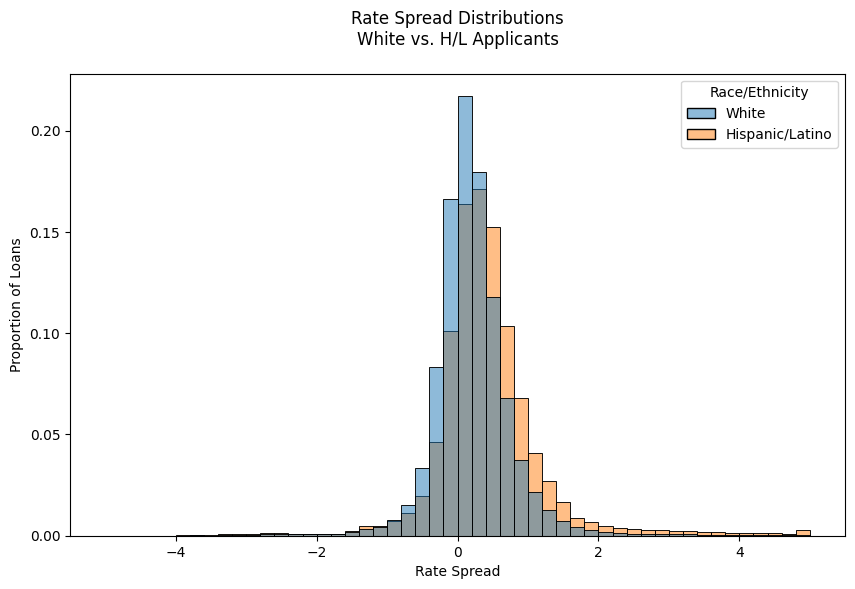

In [59]:
ax = sns.histplot(
    data=(
        raw.filter(pl.col("loan_type").eq(1))
        .with_columns(pl.col("rate_spread").clip(-5, 5))
        .with_columns(EXPR_ETHN_SIMPLE)
        .with_columns(EXPR_RACE_SIMPLE)
        .with_columns(
            EXPR_RACE_ETHN.replace(
                {
                    "hl": "Hispanic/Latino",
                    "white": "White",
                }
            )
        )
        .filter(
            pl.col("race_ethn").is_in(
                [
                    "Hispanic/Latino",
                    "White",
                ]
            )
        )
        .rename({"race_ethn": "Race/Ethnicity"})
    ),
    x="rate_spread",
    hue="Race/Ethnicity",
    stat="probability",
    common_bins=True,
    common_norm=False,
    binwidth=0.2,
)

ax.figure.set_size_inches((10, 6))
ax.set_ylabel("Proportion of Loans")
ax.set_xlabel("Rate Spread")
ax.set_title("Rate Spread Distributions\n" "White vs. H/L Applicants\n")
pass

Only a very small proportion (less than 0.05%) of rate spreads are less than -5 or +5; we'll remove them from analyses because they might be errors:

In [60]:
(raw.filter(~pl.col("rate_spread").is_null())["rate_spread"].abs().ge(5).mean())

0.0004679185993350405

## Aggregate stats, by race/ethnicity

In [61]:
AGG_RATE_SPREADS = (
    pl.col("rate_spread").mean().round(2).alias("Average").round(2),
    pl.col("rate_spread").median().round(2).alias("Median"),
    pl.col("rate_spread").gt(0.5).mean().round(2).alias("Prop. >0.5"),
    pl.col("rate_spread").gt(1).mean().round(2).alias("Prop. >1"),
)

In [62]:
(
    raw.filter(pl.col("loan_type").eq(1))
    .with_columns(EXPR_ETHN_SIMPLE)
    .with_columns(EXPR_RACE_SIMPLE)
    .group_by(EXPR_RACE_ETHN)
    .agg(AGG_RATE_SPREADS)
    .sort("Median", "Average", descending=True)
    .pipe(log, "Rate spreads descriptive stats")
)

Rate spreads descriptive stats:


race_ethn,Average,Median,Prop. >0.5,Prop. >1
str,f64,f64,f64,f64
"""black""",0.42,0.38,0.4,0.15
"""hl""",0.44,0.35,0.38,0.13
"""pacific_island…",0.4,0.32,0.34,0.12
"""native""",0.29,0.21,0.28,0.11
"""white""",0.21,0.16,0.21,0.06
"""missing""",0.19,0.13,0.21,0.06
"""asian""",0.08,0.02,0.14,0.05


In [63]:
(
    raw.filter(pl.col("loan_type").eq(1))
    .filter(pl.col("rate_spread").ge(-5))
    .filter(pl.col("rate_spread").le(5))
    .with_columns(EXPR_ETHN_SIMPLE)
    .with_columns(EXPR_RACE_SIMPLE)
    .group_by(EXPR_RACE_ETHN)
    .agg(AGG_RATE_SPREADS)
    .sort("Median", "Average", descending=True)
    .pipe(log, "Rate spreads descriptive stats, excluding outliers")
)

Rate spreads descriptive stats, excluding outliers:


race_ethn,Average,Median,Prop. >0.5,Prop. >1
str,f64,f64,f64,f64
"""black""",0.41,0.38,0.4,0.15
"""hl""",0.42,0.35,0.38,0.13
"""pacific_island…",0.4,0.32,0.34,0.12
"""native""",0.28,0.21,0.28,0.1
"""white""",0.2,0.16,0.21,0.06
"""missing""",0.18,0.13,0.2,0.06
"""asian""",0.08,0.02,0.14,0.05


In [64]:
(
    raw.filter(pl.col("loan_type").eq(1))
    .filter(pl.col("action_taken").eq(1))
    .with_columns(EXPR_ETHN_SIMPLE)
    .with_columns(EXPR_RACE_SIMPLE)
    .group_by(EXPR_RACE_ETHN)
    .agg(AGG_RATE_SPREADS)
    .sort("Median", "Average", descending=True)
    .pipe(log, "Rate spreads descriptive stats, excluding borrower-rejected")
)

Rate spreads descriptive stats, excluding borrower-rejected:


race_ethn,Average,Median,Prop. >0.5,Prop. >1
str,f64,f64,f64,f64
"""black""",0.42,0.38,0.4,0.15
"""hl""",0.43,0.35,0.38,0.13
"""pacific_island…",0.39,0.32,0.33,0.11
"""native""",0.28,0.21,0.29,0.1
"""white""",0.2,0.16,0.21,0.06
"""missing""",0.19,0.13,0.2,0.06
"""asian""",0.08,0.02,0.14,0.05


---

---

---